In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
pvtw = pd.read_csv("pvtw_merged_with_parliament_1997_2024.csv")
pvtw.shape

(78112, 50)

In [3]:
pvtw.columns

Index(['Unnamed: 0', 'event_id_cnty', 'event_date', 'time_precision',
       'disorder_type', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2',
       'interaction', 'civilian_targeting', 'iso', 'Subregion', 'country',
       'admin1', 'admin2', 'admin3', 'location', 'latitude', 'longitude',
       'geo_precision', 'source', 'source_scale', 'notes', 'fatalities',
       'tags', 'timestamp', 'Month', 'Year', 'Region', 'Lower Total Seat',
       'Lower Total Women', 'Lower Chamber Women (%)', 'Upper Total Seat',
       'Upper Total Women', 'Upper Chamber Women (%)', 'Rank',
       'Suspended Parliament', 'Structure of Parliament', 'Region_meta',
       'IPU Membership', 'Political System', 'Transitional Status',
       'gender_equality', 'themes', 'gender_quota'],
      dtype='object')

In [4]:
pvtw['disorder_type'].value_counts()

disorder_type
Demonstrations                        54339
Political violence                    22121
Strategic developments                 1459
Political violence; Demonstrations      193
Name: count, dtype: int64

In [5]:
pvtw['event_type'].value_counts()

event_type
Protests                      52811
Violence against civilians    20058
Riots                          3659
Strategic developments         1459
Explosions/Remote violence      125
Name: count, dtype: int64

In [6]:
pvtw['sub_event_type'].value_counts()

sub_event_type
Peaceful protest                      50572
Attack                                13174
Sexual violence                        3781
Abduction/forced disappearance         3103
Protest with intervention              2046
Mob violence                           1938
Violent demonstration                  1721
Arrests                                 834
Other                                   344
Looting/property destruction            279
Excessive force against protesters      193
Remote explosive/landmine/IED            52
Grenade                                  42
Air/drone strike                         16
Shelling/artillery/missile attack        10
Suicide bomb                              5
Disrupted weapons use                     2
Name: count, dtype: int64

In [7]:
pvtw['civilian_targeting'] = pvtw['civilian_targeting'].map({'Civilian targeting': 1}).fillna(0)

In [8]:
pvtw['civilian_targeting']

0        1.0
1        0.0
2        0.0
3        0.0
4        1.0
        ... 
78107    1.0
78108    1.0
78109    1.0
78110    1.0
78111    1.0
Name: civilian_targeting, Length: 78112, dtype: float64

In [9]:
missing_lower_women_data = pvtw[pvtw['Lower Total Seat'].isna()][['country', 'Subregion', 'Region']]
print(missing_lower_women_data['country'].unique())

['Palestine' 'Taiwan' 'Reunion' 'Kosovo' 'French Guiana' 'Puerto Rico'
 'Sint Maarten' 'Mayotte' 'Bailiwick Of Guernsey' 'Greenland'
 'New Caledonia' 'Martinique' 'Caribbean Netherlands' 'French Polynesia'
 'Guam' 'Saint-Martin' 'Guadeloupe' 'Curacao']


In [10]:
pvtw = pvtw[~(pvtw['country'].isin(missing_lower_women_data))]
pvtw['Lower Total Seat'].isna().sum()

756

In [11]:
def plot(kind, data, x, y, title, xlabel, ylabel, legend=True, hue=None, grid=True, legend_kwargs=None,figsize=None,rotation=None,ha=None, **kwargs):
    """
    A flexible function to plot different kinds of graphs using Seaborn.
    Parameters:
        kind (str): The type of plot (e.g., 'line', 'scatter', 'bar', etc.).
        data (DataFrame): The dataset to use for the plot.
        x (str): The column name for the x-axis.
        y (str): The column name for the y-axis.
        title (str): The title of the plot.
        xlabel (str): The label for the x-axis.
        ylabel (str): The label for the y-axis.
        legend (bool): Whether to show the legend (default: True).
        hue (str): The column name for grouping (default: None).
        grid (bool): Whether to display a grid (default: True).
        legend_kwargs (dict): Additional arguments for customizing the legend (default: None).
        **kwargs: Additional keyword arguments for the specific Seaborn plot.
    """
    sns.set_palette("bright")
    # Create a new figure if needed
    plt.figure(figsize=(10, 6))
    if figsize is not None:
        plt.figure(figsize=figsize)
    
    # Dynamically call the appropriate Seaborn plot function
    plot_func = getattr(sns, f"{kind}plot", None)
    if plot_func is None:
        raise ValueError(f"Plot type '{kind}' is not supported by Seaborn.")
    
    # If plotting a boxplot, explicitly pass the palette
    if kind == 'box':
        plot_func(data=data, x=x, y=y, hue=hue, palette="bright", **kwargs)
    else:
        plot_func(data=data, x=x, y=y, hue=hue, **kwargs)

    # # Create the plot
    # plot_func(data=data, x=x, y=y, hue=hue, **kwargs)
    
    # Add titles and labels
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    
    # Add legend if applicable
    if legend and hue:
        if legend_kwargs is None:
            legend_kwargs = {}
        plt.legend(title=hue, **legend_kwargs)
    
    if grid:
        # Add grid for better readability
        plt.grid(True, linestyle='--', alpha=0.6)
    
    if rotation is not None:
        plt.xticks(rotation=rotation, ha = ha)
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


<Figure size 1000x600 with 0 Axes>

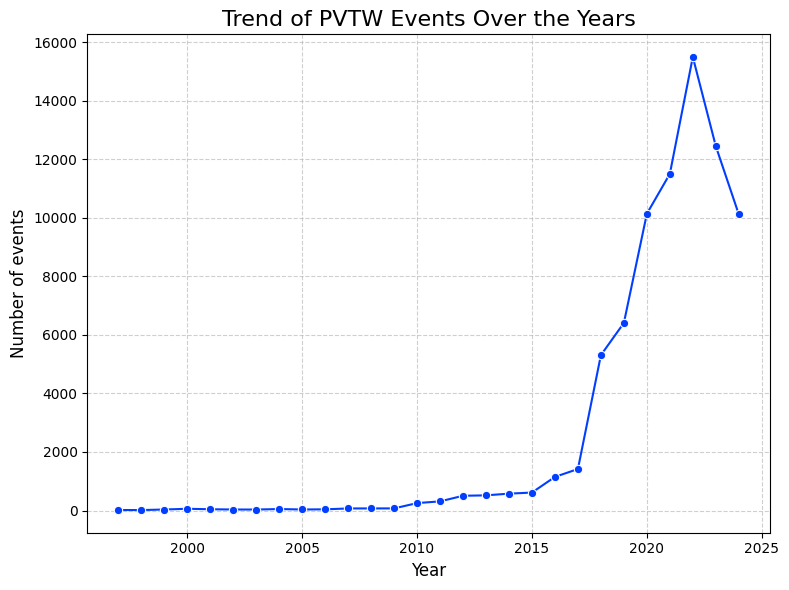

In [12]:
events_per_year_df = pvtw['Year'].value_counts().sort_index().reset_index()
events_per_year_df.columns = ['Year', 'Number of Events']

plot('line',events_per_year_df,events_per_year_df['Year'],events_per_year_df['Number of Events'],'Trend of PVTW Events Over the Years',
     'Year','Number of events',marker='o', linestyle='-',figsize=(8,6))

<Figure size 1000x600 with 0 Axes>

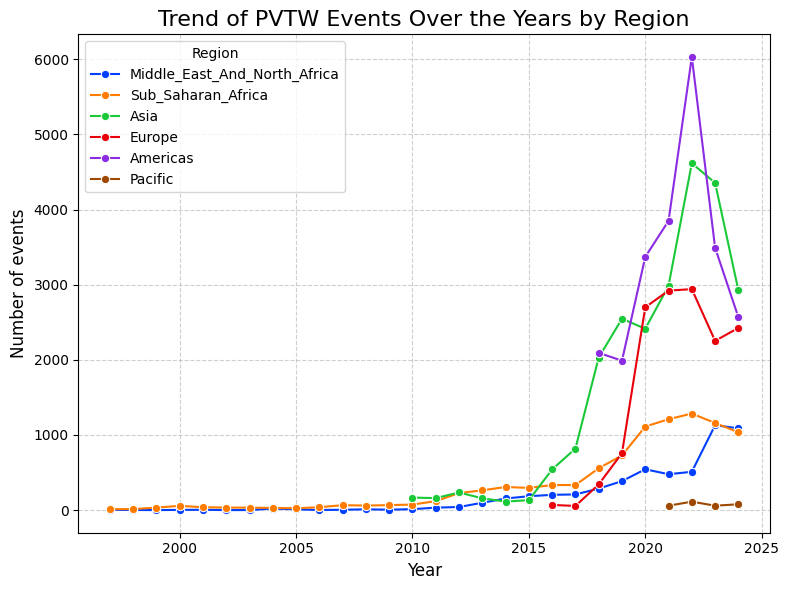

In [13]:
events_per_year_region_df = pvtw.groupby(['Year', 'Region']).size().reset_index(name='Number of Events')

plot('line',events_per_year_region_df,events_per_year_region_df['Year'],events_per_year_region_df['Number of Events'],"Trend of PVTW Events Over the Years by Region",
     'Year','Number of events',marker='o', linestyle='-',figsize=(8,6),legend=True,hue='Region')

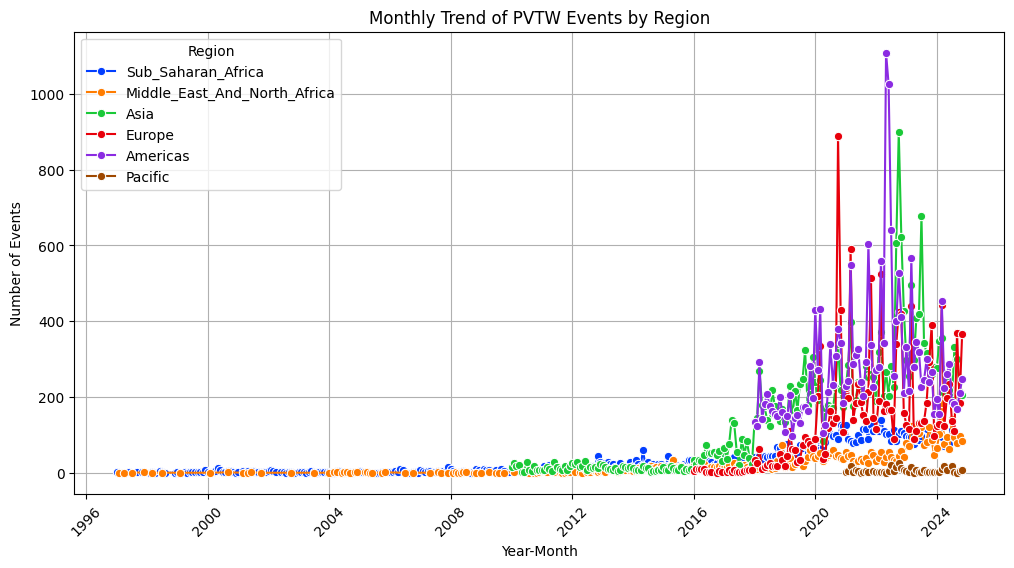

In [14]:
events_per_month_region_df = pvtw.groupby(['Year', 'Month', 'Region']).size().reset_index(name='Number of Events')

# Convert Year and Month to a datetime format
events_per_month_region_df['Date'] = pd.to_datetime(events_per_month_region_df[['Year', 'Month']].assign(day=1))

# Plot Monthly Trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=events_per_month_region_df, x='Date', y='Number of Events', hue='Region', marker='o')

plt.title("Monthly Trend of PVTW Events by Region")
plt.xlabel("Year-Month")
plt.ylabel("Number of Events")
plt.xticks(rotation=45)
plt.legend(title="Region")
plt.grid(True)
plt.show()

In [15]:
events_per_month_region_df

,Year,Month,Region,Number of Events,Date
0,1997.0,1,Sub_Saharan_Africa,3,1997-01-01
1,1997.0,2,Middle_East_And_North_Africa,1,1997-02-01
2,1997.0,3,Sub_Saharan_Africa,1,1997-03-01
3,1997.0,4,Middle_East_And_North_Africa,1,1997-04-01
4,1997.0,4,Sub_Saharan_Africa,1,1997-04-01
...,...,...,...,...,...
945,2024.0,11,Asia,206,2024-11-01
946,2024.0,11,Europe,366,2024-11-01
947,2024.0,11,Middle_East_And_North_Africa,84,2024-11-01
948,2024.0,11,Pacific,7,2024-11-01


Those overall trend is misleading due to lack of data in earlier years and regional biases. So proceed to do furthur 
analysis with normalized events per month.

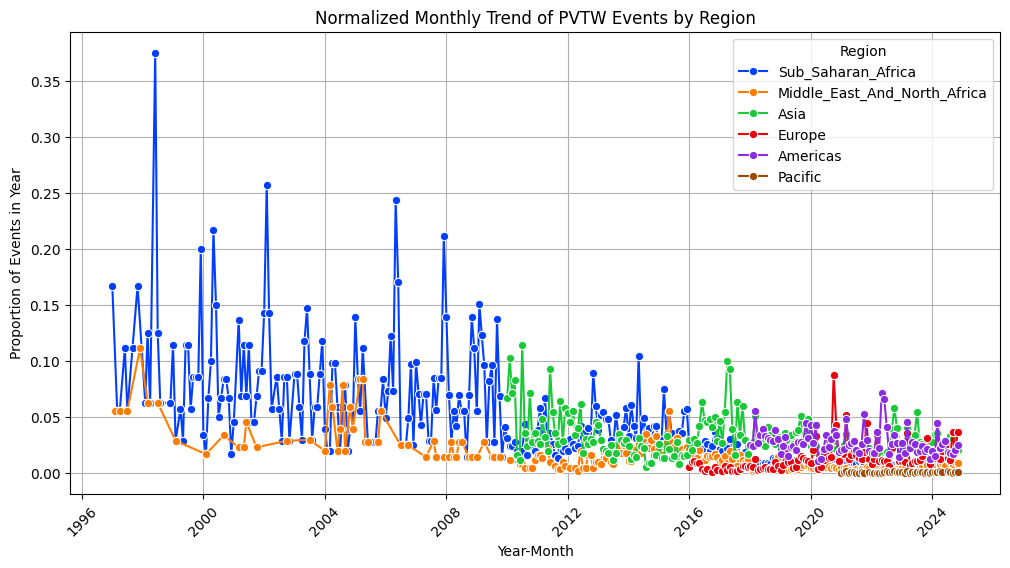

In [16]:
#How do the proportions of PVTW events vary across different regions over time, and are there any notable spikes or trends in specific regions?

# Count total events per year
total_events_per_year = pvtw.groupby('Year').size().rename("Total Events in Year")

# Merge with monthly data
events_per_month_region_df = events_per_month_region_df.merge(total_events_per_year, on="Year")

# Normalize: Divide each month's event count by total events in that year
events_per_month_region_df['Normalized Events'] = events_per_month_region_df['Number of Events'] / events_per_month_region_df['Total Events in Year']

# Plot Normalized Monthly Trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=events_per_month_region_df, x='Date', y='Normalized Events', hue='Region', marker='o')

plt.title("Normalized Monthly Trend of PVTW Events by Region")
plt.xlabel("Year-Month")
plt.ylabel("Proportion of Events in Year")
plt.xticks(rotation=45)
plt.legend(title="Region")
plt.grid(True)
plt.show()

# plot('line',events_per_month_region_df,'Date','Normalized Events',"Normalized Monthly Trend of PVTW Events by Region","Year-Month","Proportion of Events in Year",
#      legend=True,hur='Region',marker='o',rotation=45,ha='right',figsize=(12,6))


                   event type  Number of events
0                    Protests             52811
1  Violence against civilians             20058
2                       Riots              3659
3      Strategic developments              1459
4  Explosions/Remote violence               125


<Figure size 1000x600 with 0 Axes>

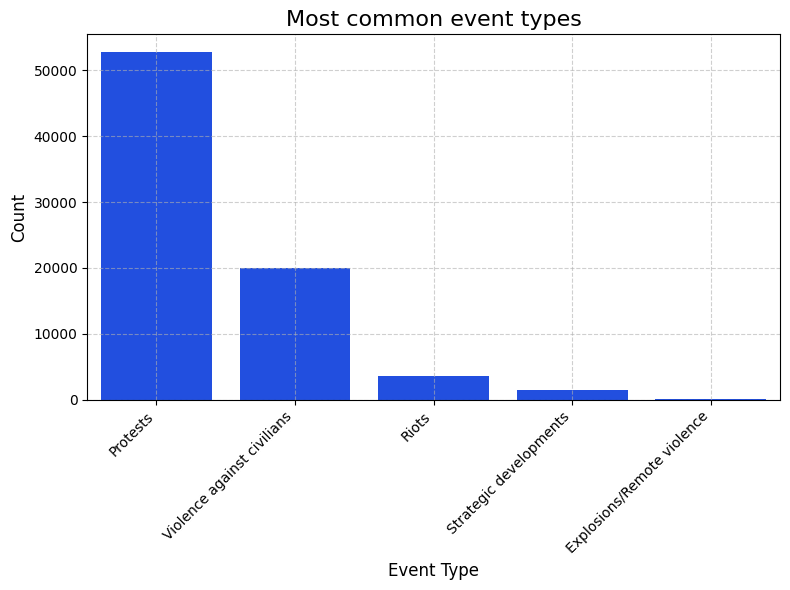

In [17]:
# What are the most common types of PVTW events, and how does their frequency compare across the different categories?

# Top event types
top_event_types = pvtw['event_type'].value_counts().sort_values(ascending=False).reset_index()
top_event_types.columns = ['event type','Number of events']
print(top_event_types)

plot('bar',top_event_types,'event type','Number of events','Most common event types','Event Type','Count',figsize=(8,6),rotation=45,ha='right')

<Figure size 1000x600 with 0 Axes>

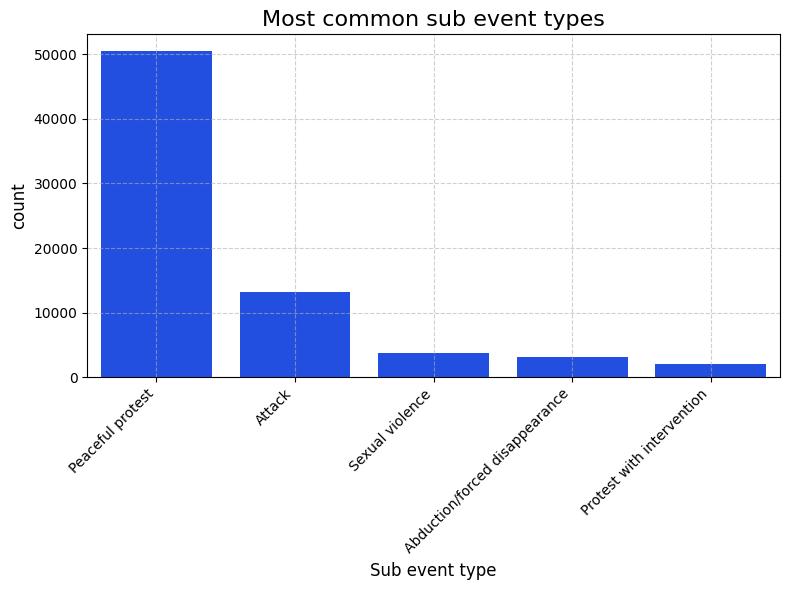

In [18]:
#Which sub-event types are most frequently associated with political violence targeting women, and how do they contribute to the overall patterns of violence?
# Top sub-event types
top_sub_event_types = pvtw['sub_event_type'].value_counts().sort_values(ascending=False).reset_index().head(5)
top_sub_event_types.columns = ['sub event type','count']
plot('bar',top_sub_event_types,'sub event type','count','Most common sub event types','Sub event type','count',rotation=45, ha='right',
     figsize=(8,6))

<Figure size 1000x600 with 0 Axes>

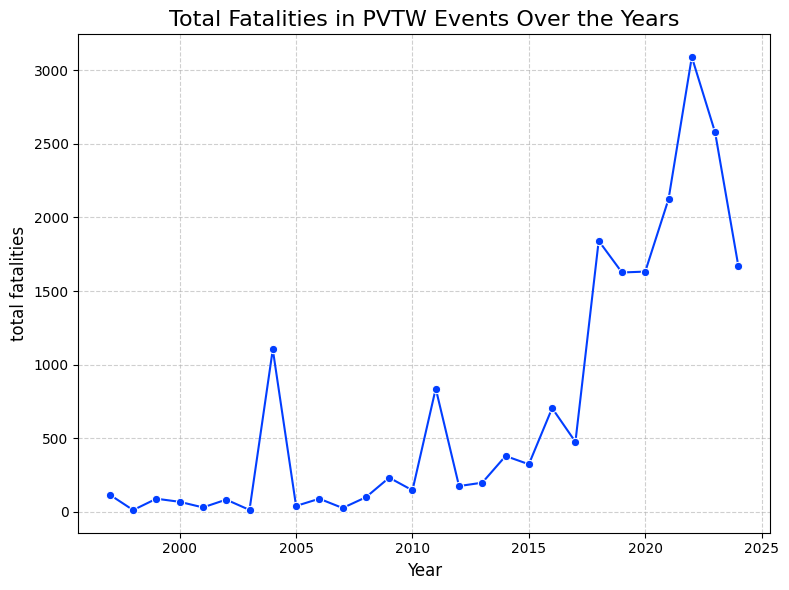

In [19]:
fatalities_per_year = pvtw.groupby('Year')['fatalities'].sum().reset_index()
plot('line',fatalities_per_year,'Year','fatalities','Total Fatalities in PVTW Events Over the Years','Year','total fatalities',marker='o',
     linestyle = '-', figsize=(8,6))

Those overall trend is misleading due to lack of data in earlier years. So proceed to do furthur 
analysis with normalized events per year-month by grouding the data.

In [28]:
#How has the normalized fatality rate (fatalities per event) evolved over time in political violence targeting women, and what trends or spikes can be observed across the years?
# Group by Year and calculate total fatalities and total events
fatalities_per_year = pvtw.groupby('Year')['fatalities'].sum().reset_index()
events_per_year = pvtw.groupby('Year').size().reset_index(name='Number of Events')

# Merge the two dataframes
fatalities_per_year = fatalities_per_year.merge(events_per_year, on="Year")

# Normalize fatalities (fatalities per event)
fatalities_per_year['Fatalities Rate'] = fatalities_per_year['fatalities'] / fatalities_per_year['Number of Events']

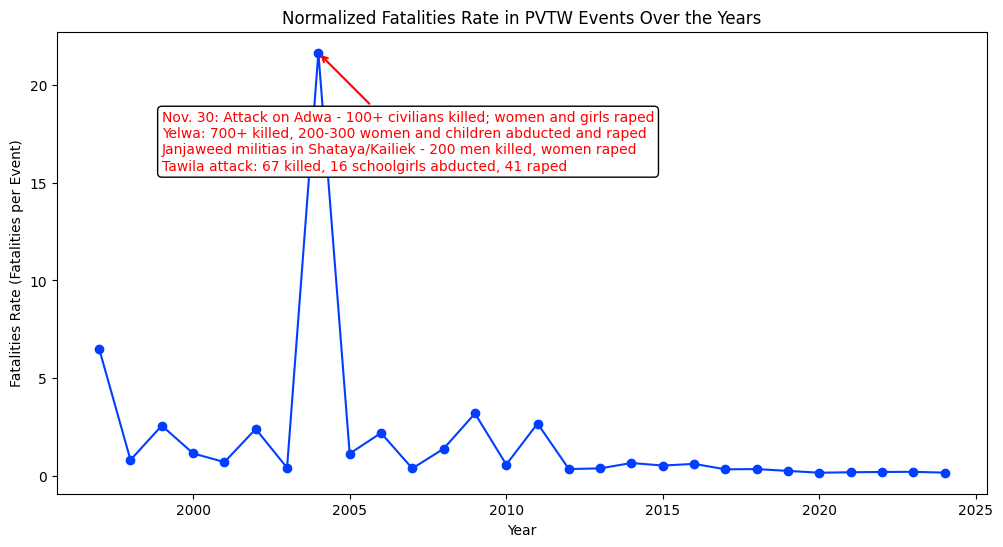

In [29]:
#How has the normalized fatality rate (fatalities per event) evolved over time in political violence targeting women, and what trends or spikes can be observed across the years?
# Find the 2004 data point
plt.figure(figsize=(12,6))
plt.plot(fatalities_per_year['Year'], fatalities_per_year['Fatalities Rate'], marker='o', linestyle='-')

# Find the 2004 data point
year_2004 = 2004
fatalities_2004 = fatalities_per_year.loc[fatalities_per_year['Year'] == year_2004, 'Fatalities Rate'].values[0]

# Multi-line annotation text
annotation_text = (
    "Nov. 30: Attack on Adwa - 100+ civilians killed; women and girls raped\n"
    "Yelwa: 700+ killed, 200-300 women and children abducted and raped\n"
    "Janjaweed militias in Shataya/Kailiek - 200 men killed, women raped\n"
    "Tawila attack: 67 killed, 16 schoolgirls abducted, 41 raped"
)

# Annotate the spike with adjusted positioning
plt.annotate(
    annotation_text,  
    xy=(year_2004, fatalities_2004),  # Arrow tip at the data point
    xytext=(year_2004 - 5, fatalities_2004 - 6),  # Move text down and slightly left
    arrowprops=dict(
        arrowstyle='->', 
        color='red', 
        lw=1.5,
        connectionstyle="angle,angleA=0,angleB=-45,rad=10"  # Longer curved arrow
    ),  
    fontsize=10,
    color='red',
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white')  # Background for better readability
)

# Labels and title
plt.xlabel('Year')
plt.ylabel('Fatalities Rate (Fatalities per Event)')
plt.title('Normalized Fatalities Rate in PVTW Events Over the Years')
plt.show()

    Nov. 30: Attack on Adwa - 100+ civilians killed; women and girls raped
    Yelwa: 700+ killed, 200-300 women and children abducted and raped
    Janjaweed militias in Shataya/Kailiek - 200 men killed, women raped
    Tawila attack: 67 killed, 16 schoolgirls abducted, 41 raped


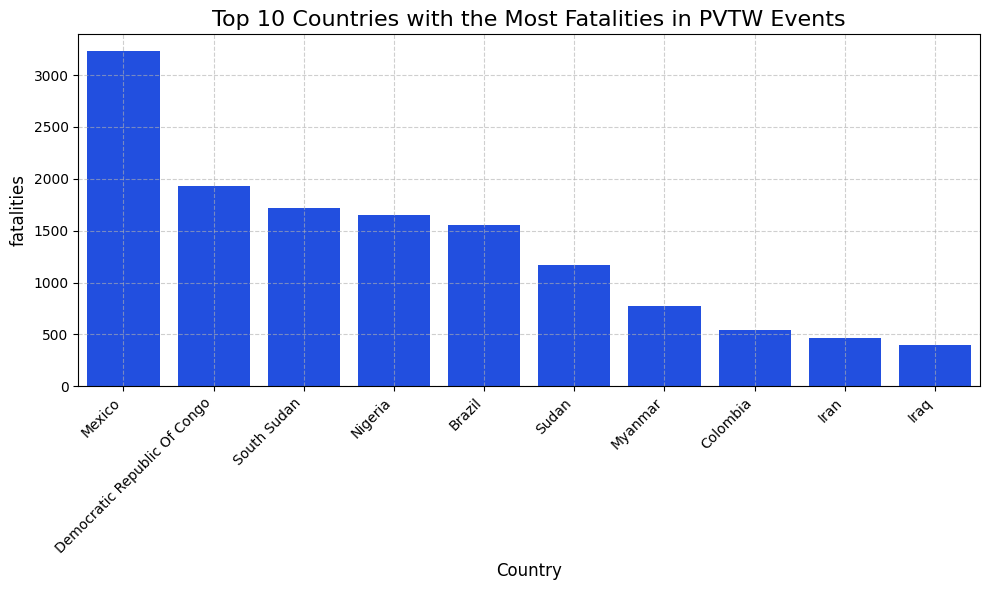

In [ ]:
fatalities_per_country = pvtw.groupby('country')['fatalities'].sum().reset_index()
top_fatalities_country = fatalities_per_country.sort_values(by='fatalities',ascending=False).head(10)
lowest_fatalities_country = fatalities_per_country.sort_values(by='fatalities',ascending=False).tail(10)
plot('bar',top_fatalities_country,'country','fatalities','Top 10 Countries with the Most Fatalities in PVTW Events',
     'Country','fatalities',rotation=45, ha='right')

# plot('bar',lowest_fatalities_country,'country','fatalities','lowest 10 Countries with the Most Fatalities in PVTW Events',
#      'Country','fatalities',rotation=45, ha='right')

                         country       disorder_type  count
20                        Mexico  Political violence   3415
1                         Brazil  Political violence   1963
11                          Iran      Demonstrations   1962
8   Democratic Republic Of Congo  Political violence   1289
35                         Sudan  Political violence    978
28                       Nigeria  Political violence    897
24                       Myanmar  Political violence    737
5                       Colombia  Political violence    733
32                   South Sudan  Political violence    521
16                          Iraq  Political violence    180


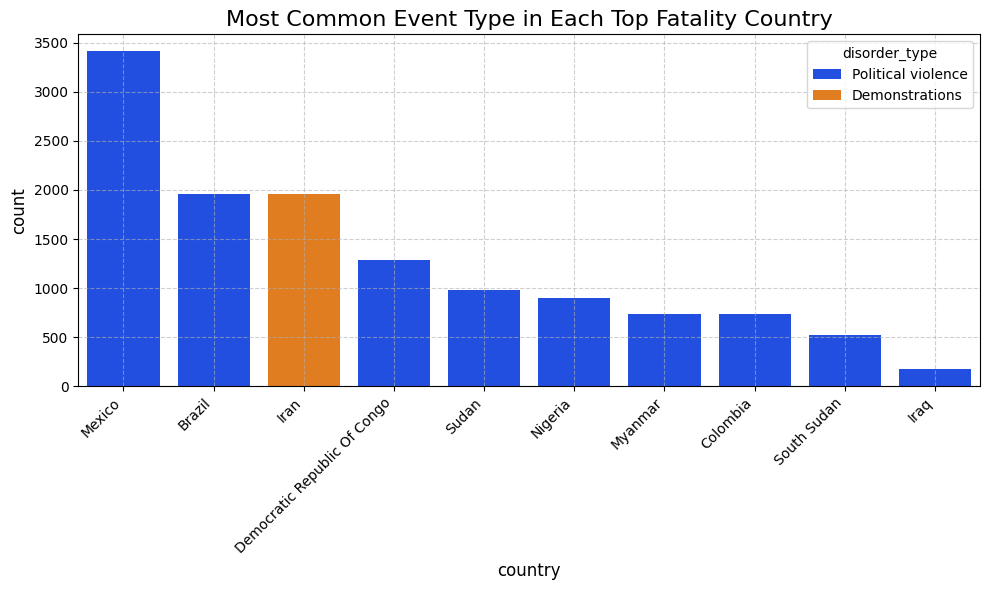

In [ ]:
# What are the most common types of events associated with political violence targeting women in the countries with the highest fatalities, and how do these events differ across countries?
# Get the list of top fatality countries
top_countries = top_fatalities_country['country'].tolist()

# Filter dataset for these countries
filtered_pvtw = pvtw[pvtw['country'].isin(top_countries)]
# Count occurrences of each event_type per country
event_type_counts = filtered_pvtw.groupby(['country', 'disorder_type']).size().reset_index(name='count')

# Get the most common event type for each country
most_common_event_type = event_type_counts.loc[event_type_counts.groupby('country')['count'].idxmax()].sort_values(by='count',ascending=False)

# Display the results
print(most_common_event_type)
plot('bar',most_common_event_type,'country','count','Most Common Event Type in Each Top Fatality Country','country','count',
     hue='disorder_type',rotation=45,ha='right')

In [ ]:
pvtw['inter1'].value_counts()

inter1
Protesters               52786
Political militia        12636
State forces              5012
Rioters                   3666
Rebel group               2309
Identity militia          1231
External/Other forces      449
Civilians                   23
Name: count, dtype: int64

In [ ]:
pvtw['inter2'].value_counts()

inter2
Civilians                23665
State forces              2978
Protesters                1083
Rioters                    214
External/Other forces       40
Political militia           26
Rebel group                 23
Identity militia             1
Name: count, dtype: int64

<Figure size 1000x600 with 0 Axes>

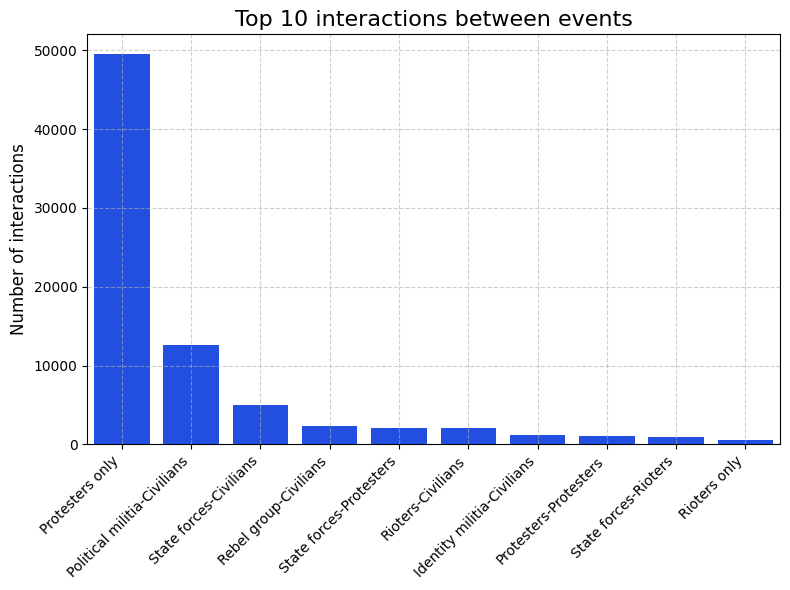

In [ ]:
#What are the most frequent interactions between different types of events in political violence targeting women, and how do these interactions impact the overall dynamics of violence?
top_iteractions = pvtw['interaction'].value_counts().reset_index().sort_values(by='count',ascending=False).head(10)
top_iteractions
plot('bar',top_iteractions,'interaction','count',"Top 10 interactions between events",'','Number of interactions',
     figsize=(8,6),rotation=45,ha='right')

Most Common Actor Pairs Targeting Civilians:
                                               index  count
0                  Rioters - Vigilante Group (India)    207
1          Identity militia - Pastoralists (Nigeria)     92
2            Identity militia - Pastoralists (Sudan)     86
3                  Rioters - Vigilante Group (Kenya)     72
4    Political militia - Government of China (2012-)     63
5  Rioters - Vigilante Group (Democratic Republic...     61
6                  Rioters - Vigilante Group (Nepal)     58
7           Rioters - Vigilante Group (South Africa)     52
8  Rebel group - YDG-H: Patriotic Revolutionary Y...     51
9  Rebel group - Ambazonian Separatists (Cameroon...     45

Most Common Women Groups Targeted:
                                              index  count
0                        Civilians - Women (Mexico)   2811
1                        Civilians - Women (Brazil)   1686
2  Civilians - Women (Democratic Republic of Congo)   1069
3                      

<Figure size 1000x600 with 0 Axes>

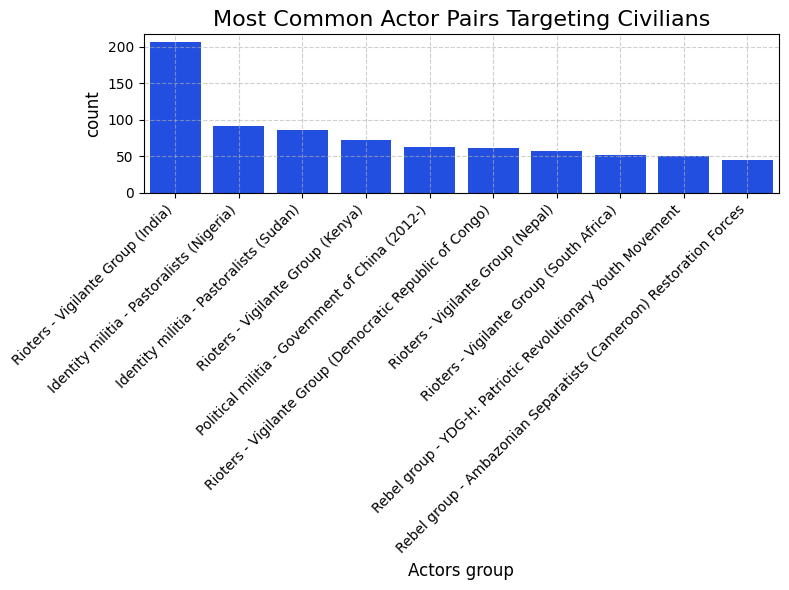

<Figure size 1000x600 with 0 Axes>

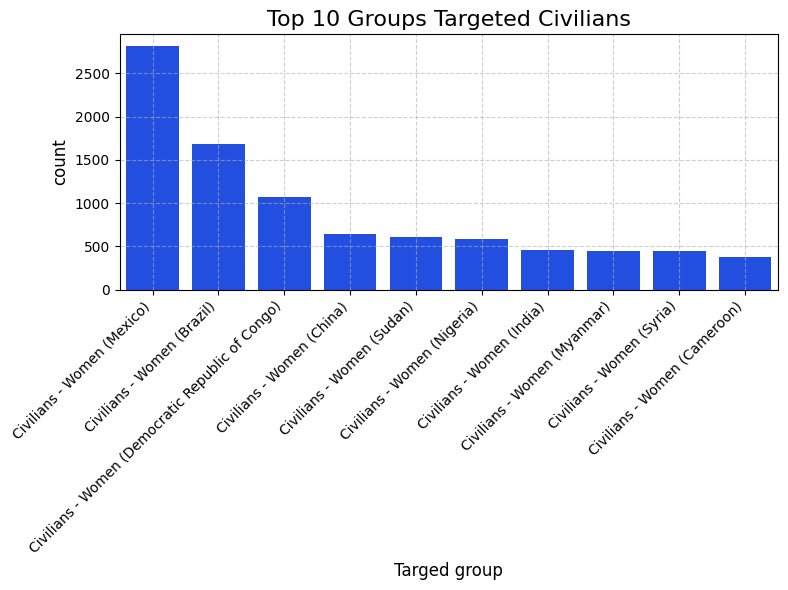

In [ ]:
# Step 1: Filter events where civilian_targeting is 'Civilian targeting'
civilian_targeting_df = pvtw[pvtw['civilian_targeting'] == 1.0]

# Step 2: Analyze the most common actors and women groups involved
# Combine actor1 and assoc_actor_1 to see who is targeting civilians
actors_involved = civilian_targeting_df['inter1'] + ' - ' + civilian_targeting_df['assoc_actor_1']

# Combine actor2 and assoc_actor_2 to identify which groups of women are targeted
targeted_groups = civilian_targeting_df['inter2'] + ' - ' + civilian_targeting_df['assoc_actor_2']

# Count the frequency of actor pairs and women targeted
actor_pairs_counts = actors_involved.value_counts().reset_index().head(10)
targeted_groups_counts = targeted_groups.value_counts().reset_index().head(10)

# Step 3: Display the most frequent actors targeting civilians and women being targeted
print("Most Common Actor Pairs Targeting Civilians:")
print(actor_pairs_counts.head(10))

print("\nMost Common Women Groups Targeted:")
print(targeted_groups_counts.head(10))
# Which actor pairs are most frequently involved in targeting civilians, and how do these interactions shape the landscape of political violence?
plot('bar',actor_pairs_counts,'index','count','Most Common Actor Pairs Targeting Civilians','Actors group','count',
     rotation=45, ha='right',figsize=(8,6))
#Which groups of women are most commonly targeted in political violence, and what does this reveal about the nature of civilian and gender-based violence in these conflicts?
plot('bar',targeted_groups_counts,'index','count','Top 10 Groups Targeted Civilians','Targed group','count',rotation=45,ha='right',figsize=(8,6))

<Figure size 1000x600 with 0 Axes>

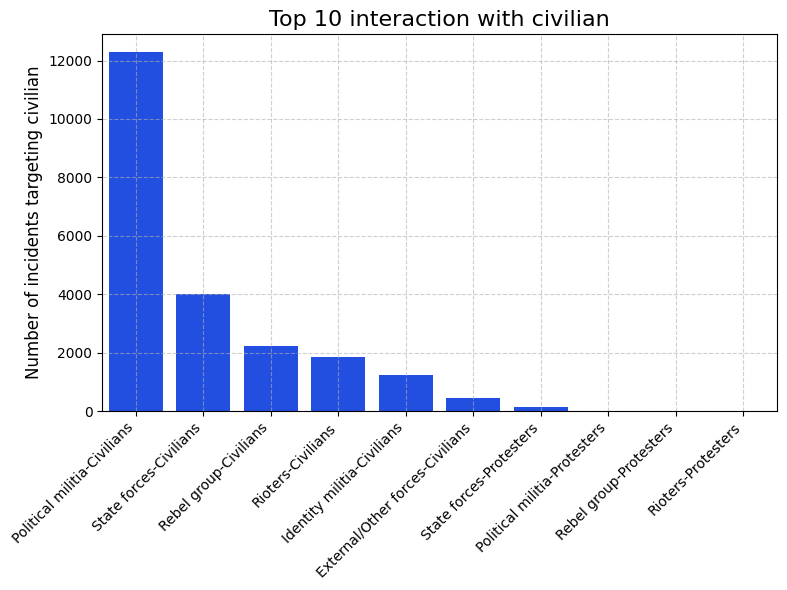

In [ ]:
#What are the most frequent types of interactions involving civilians in political violence, and how do these interactions correlate with the scale and intensity of civilian targeting?
civilian_interaction =civilian_targeting_df.groupby('interaction')['civilian_targeting'].size().reset_index().sort_values(by='civilian_targeting',ascending=False).head(10)
civilian_interaction
plot('bar',civilian_interaction,'interaction','civilian_targeting',"Top 10 interaction with civilian",'','Number of incidents targeting civilian',
     figsize=(8,6),rotation=45,ha='right')

<Figure size 1000x600 with 0 Axes>

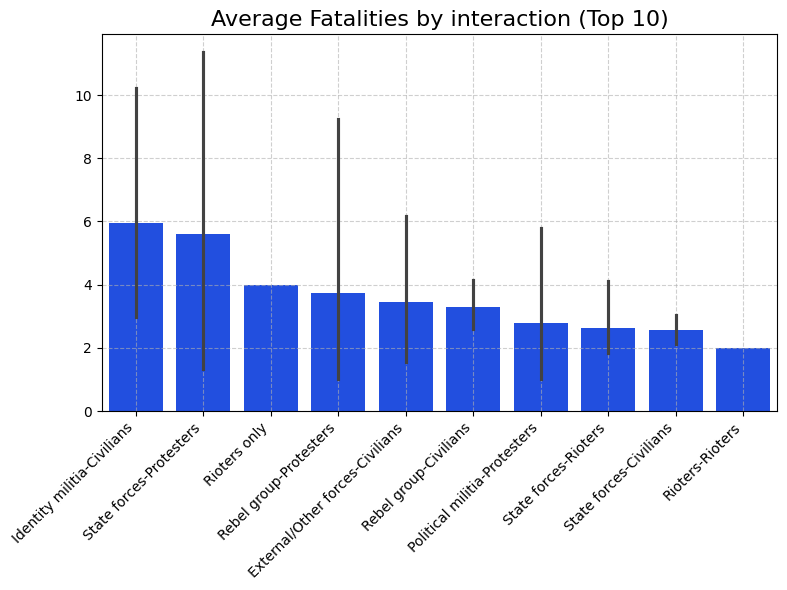

In [ ]:
#Which types of interactions result in the highest number of fatalities, and how do these interactions differ in terms of severity and impact on civilian populations?
interaction_fatality = pvtw[pvtw['fatalities'] > 0 ]
# Get top 5 interactions by median fatalities
top_interactions = interaction_fatality.groupby('interaction')['fatalities'].mean().nlargest(10).index.tolist()

top_interactions
# Filter data for top 5 interactions
filtered_data = interaction_fatality[interaction_fatality['interaction'].isin(top_interactions)]
# plot('box',interaction_fatality,'interaction','fatalities','Fatalities by interaction (Top 5)','','',rotation=45, ha='right',
#      order=top_interactions, figsize=(8,6))

plot('bar',interaction_fatality,'interaction','fatalities','Average Fatalities by interaction (Top 10)','','',order=top_interactions,rotation=45, ha='right',
     figsize=(8,6))

correlation can't see clearly in the overall dataset

Overall trend might mislead -due to rarity of fatality over the years. There are lots of non fatality cases and non normality data.
DO furthur analysis on monthly aggregated data.
There are no strong correlation in overall trend, need furthur analysis to avoid bias across datasets

C:\Users\nuwai\AppData\Local\Temp\ipykernel_11268\3663139388.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_func(data=data, x=x, y=y, hue=hue, palette="bright", **kwargs)


<Figure size 1000x600 with 0 Axes>

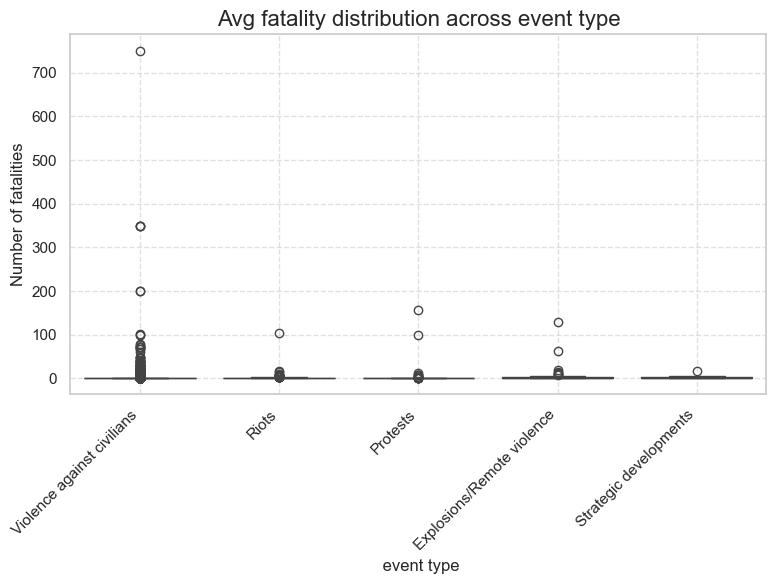

In [ ]:
#How do the distributions of fatalities vary across different event types, and which event types exhibit the highest variability or outliers in terms of fatality rates?
# Group by event type and calculate average fatalities
pvtw_fatality = pvtw[pvtw['fatalities'] >0]
avg_fatality_rates = pvtw_fatality.groupby('event_type')['fatalities'].mean().reset_index()

plot('box',pvtw_fatality,'event_type','fatalities','Avg fatality distribution across event type',' event type','Number of fatalities',
     figsize=(8,6),rotation=45, ha='right')


<Figure size 1000x600 with 0 Axes>

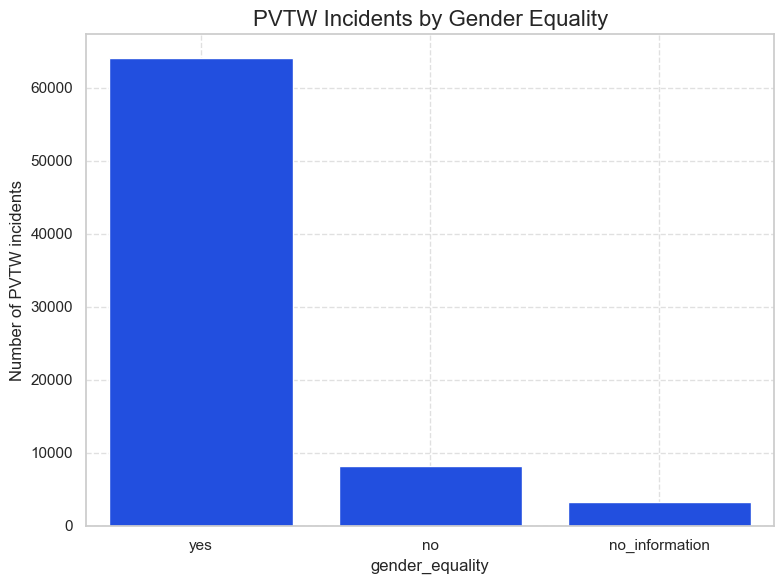

In [ ]:
# Do countries with stronger gender equality policies experience lower levels of PVTW?
# Group by gender equality and count PVTW incidents
equality_pvtw = pvtw.groupby('gender_equality')['event_id_cnty'].count().reset_index().sort_values(by='event_id_cnty',ascending=False)
plot('bar',equality_pvtw,'gender_equality', 'event_id_cnty', 'PVTW Incidents by Gender Equality','gender_equality','Number of PVTW incidents',
     figsize=(8,6))


<Figure size 1000x600 with 0 Axes>

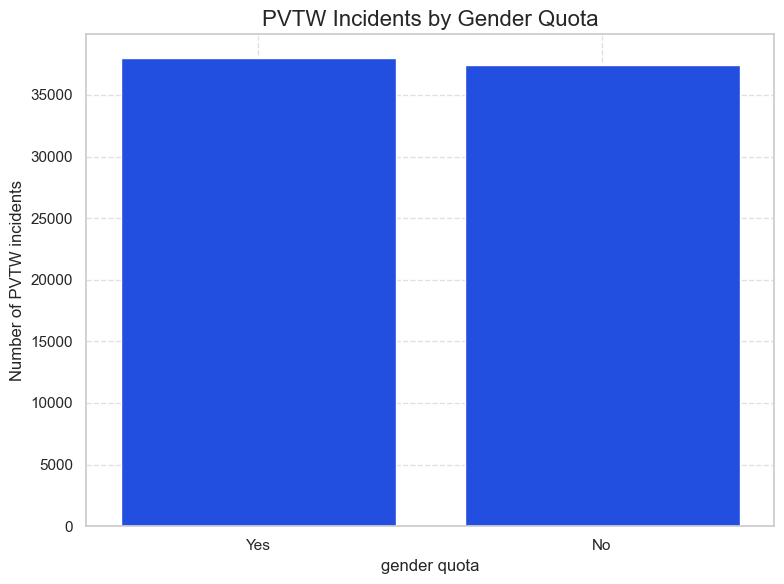

In [ ]:
#How do PVTW incidents differ between countries with and without gender quotas in their political systems, and do gender quotas seem to influence the frequency of such incidents?
quota_pvtw = pvtw.groupby('gender_quota')['event_id_cnty'].count().reset_index().sort_values(by='event_id_cnty',ascending=False)
plot('bar',quota_pvtw,'gender_quota', 'event_id_cnty', 'PVTW Incidents by Gender Quota','gender quota','Number of PVTW incidents',
     figsize=(8,6))

In [ ]:
# #How does the type of political system (democracy vs. autocracy) impact PVTW incidents?
# political_system_pvtw = pvtw.groupby('Political System')['event_id_cnty'].count().reset_index().sort_values(by='event_id_cnty',ascending=False)
# plot('bar',political_system_pvtw,'Political System', 'event_id_cnty', 'PVTW Incidents by Political system','Political System','Number of PVTW incidents',
#      figsize=(8,6),rotation=45, ha='right')

<Figure size 1000x600 with 0 Axes>

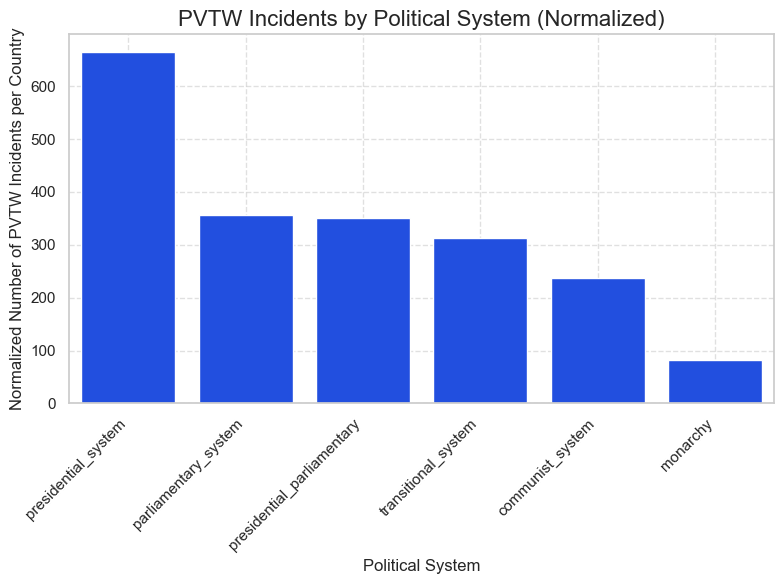

In [ ]:
# How does the type of political system (democracy vs. autocracy) impact PVTW incidents?

# Count the number of countries in each political system
countries_per_system = pvtw.groupby('Political System')['country'].nunique().reset_index()

# Group by political system and count PVTW incidents
political_system_pvtw = pvtw.groupby('Political System')['event_id_cnty'].count().reset_index()

# Merge the two dataframes to get the number of countries
political_system_pvtw = political_system_pvtw.merge(countries_per_system, on='Political System')

# Normalize the incidents by the number of countries
political_system_pvtw['incidents_per_country'] = political_system_pvtw['event_id_cnty'] / political_system_pvtw['country']

# Sort by normalized incidents per country
political_system_pvtw = political_system_pvtw.sort_values(by='incidents_per_country', ascending=False)

# Plot normalized PVTW incidents per country by political system
plot('bar', political_system_pvtw, 'Political System', 'incidents_per_country', 
     'PVTW Incidents by Political System (Normalized)', 'Political System', 
     'Normalized Number of PVTW Incidents per Country', figsize=(8,6), rotation=45, ha='right')

In [ ]:
# structure_pvtw = pvtw.groupby('Structure of Parliament')['event_id_cnty'].count().reset_index().sort_values(by='event_id_cnty',ascending=False)
# plot('bar',structure_pvtw,'Structure of Parliament', 'event_id_cnty', 'PVTW Incidents by Structure of Parliament','Structure of Parliament','Number of PVTW incidents',
#      figsize=(8,6),rotation=45, ha='right')

<Figure size 1000x600 with 0 Axes>

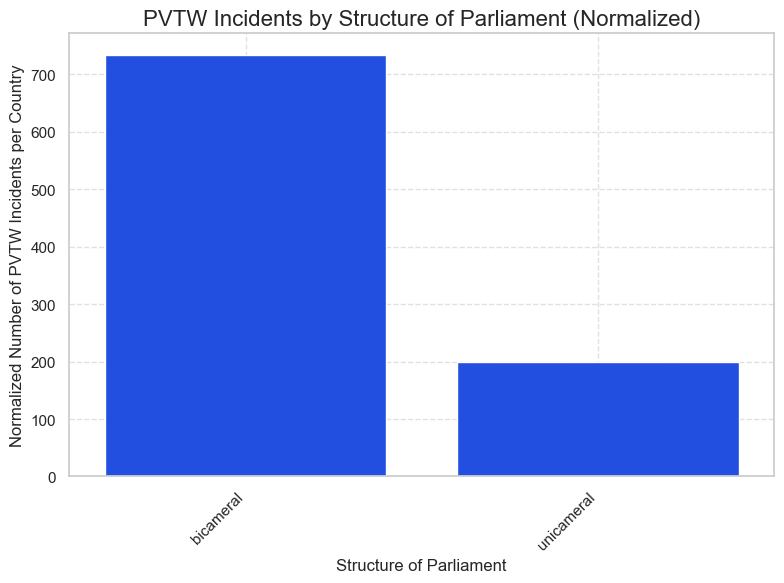

In [ ]:
#How do normalized PVTW incidents per country differ between unicameral and bicameral parliamentary structures, and does the structure of parliament influence the frequency of these incidents across countries?
# Count the number of countries in each parliamentary structure
countries_per_structure = pvtw.groupby('Structure of Parliament')['country'].nunique().reset_index()

# Group by Structure of Parliament and count PVTW incidents
structure_pvtw = pvtw.groupby('Structure of Parliament')['event_id_cnty'].count().reset_index()

# Merge the two dataframes to get the number of countries for each structure
structure_pvtw = structure_pvtw.merge(countries_per_structure, on='Structure of Parliament')

# Normalize the incidents by the number of countries in each structure
structure_pvtw['incidents_per_country'] = structure_pvtw['event_id_cnty'] / structure_pvtw['country']

# Sort by normalized incidents per country
structure_pvtw = structure_pvtw.sort_values(by='incidents_per_country', ascending=False)

# Plot normalized PVTW incidents per country by structure of parliament
plot('bar', structure_pvtw, 'Structure of Parliament', 'incidents_per_country', 
     'PVTW Incidents by Structure of Parliament (Normalized)', 'Structure of Parliament', 
     'Normalized Number of PVTW Incidents per Country', figsize=(8,6), rotation=45, ha='right')

In [ ]:
# How does PVTW compare in transitional vs. stable governments?
transitional_pvtw = pvtw.groupby('Transitional Status')['fatalities'].sum().reset_index()
transitional_pvtw

,Transitional Status,fatalities
0,False,17156
1,True,2166


In [ ]:
# import nltk
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# from collections import Counter
# # Download NLTK resources (run once)
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# # Initialize lemmatizer and stopwords
# lemmatizer = WordNetLemmatizer()
# stop_words = set(stopwords.words('english'))
# # Filter PVTW events
# pvtw_notes = pvtw[pvtw['actor2'].str.contains('women|female', case=False, na=False)]['notes'].dropna()

# # Clean text
# stop_words = set(stopwords.words('english'))
# keywords = []
# for note in pvtw['notes']:
#     words = note.lower().split()
#     words = [word for word in words if word.isalpha() and word not in stop_words]
#     # Lemmatize each word
#     lemmatized_words = [lemmatizer.lemmatize(word, pos='n')  # Treat all words as nouns
#                         for word in words]
#     keywords.extend(lemmatized_words)

# keyword_counts = Counter(keywords).most_common(20)
# print(keyword_counts)

# plt.figure(figsize=(10, 6))
# sns.barplot(x=[k[0] for k in keyword_counts], y=[k[1] for k in keyword_counts])
# plt.title('Top 20 Keywords in PVTW Notes')
# plt.xticks(rotation=45)
# plt.show()

<Figure size 1000x600 with 0 Axes>

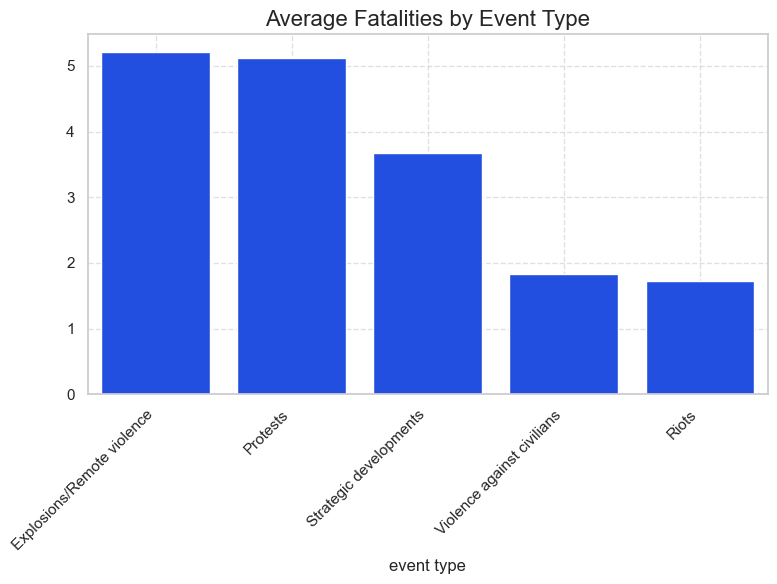

In [ ]:
#How do fatality rates vary across different types of political violence against women, and which event types are associated with the highest average fatalities?
#  How do fatality rates vary across different types of political violence against women?
fatality_rates = pvtw_fatality.groupby('event_type')['fatalities'].mean().reset_index().sort_values(by='fatalities',ascending=False)
plot('bar',fatality_rates,'event_type','fatalities','Average Fatalities by Event Type','event type','',rotation=45,ha='right',
     figsize=(8,6))

Furthur analyse after removing outliers and see still see the correlation to avoid the outliers driving the correlation.

Since the number of events and total fatalities have a positive relationship, as expected, I will use only total fatalities as a feature to avoid redundancy and minimize the risk of double-counting effects in statistical tests.

In [ ]:
# # Convert event_date to datetime (if not already)
# filtered_data['event_time'] = filtered_data['event_date'].to_timestamp

# # Group by year and month to get monthly counts of events
# filtered_data['year'] = filtered_data['event_date'].dt.year
# monthly_data = filtered_data.groupby('year').agg(
#     number_of_events=('event_time', 'count'),
#     avg_transitional_status_proportion=('transitional_status_proportion', 'sum')
# ).reset_index()

# # Normalize by dividing the proportion by the number of events in that month
# monthly_data['normalized_transitional_status'] = monthly_data['avg_transitional_status_proportion'] / monthly_data['number_of_events']

# # Plot the normalized data
# plot('line', monthly_data, 'year', 'normalized_transitional_status', 'Transitional Proportion across the year', '', '',figsize=(8,6))

In [ ]:
# Aggregating by subregion to get sum of fatalities and mean civilian targeting
pvtw_by_subregions = pvtw.groupby('Subregion').agg({
    'fatalities': 'sum',               # Sum of fatalities
    'civilian_targeting': 'mean'       # Mean of civilian targeting
}).reset_index()

pvtw_by_subregions['Number of Events'] = pvtw.groupby('Subregion')['event_type'].transform('count')

# # Choose a scaler (StandardScaler or MinMaxScaler)
# scaler = StandardScaler()  # or MinMaxScaler()

# # Standardize or normalize the data
# pvtw_by_subregions['scaled_fatalities'] = scaler.fit_transform(pvtw_by_subregions[['fatalities']])
# pvtw_by_subregions['scaled_civilian_targeting'] = scaler.fit_transform(pvtw_by_subregions[['civilian_targeting']])

# manual normalize
pvtw_by_subregions['normalized_fatalities'] = pvtw_by_subregions['fatalities'] / pvtw_by_subregions['Number of Events']
pvtw_by_subregions['normalized_civilian_targeting'] = pvtw_by_subregions['civilian_targeting'] / pvtw_by_subregions['Number of Events']
pvtw_by_subregions

,Subregion,fatalities,civilian_targeting,Number of Events,normalized_fatalities,normalized_civilian_targeting
0,Caribbean,565,0.652482,1529,0.369523,0.000427
1,Caucasus and Central Asia,150,0.279861,9477,0.015828,0.000030
2,Central America,884,0.605625,9477,0.093278,0.000064
3,East Asia,21,0.165777,3052,0.006881,0.000054
4,Eastern Africa,3120,0.802752,2763,1.129207,0.000291
5,Europe,106,0.041214,1325,0.080000,0.000031
6,Middle Africa,2476,0.850040,9477,0.261264,0.000090
7,Middle East,1620,0.167564,10943,0.148040,0.000015
8,North America,3277,0.257838,10943,0.299461,0.000024
9,Northern Africa,1289,0.625722,10943,0.117792,0.000057


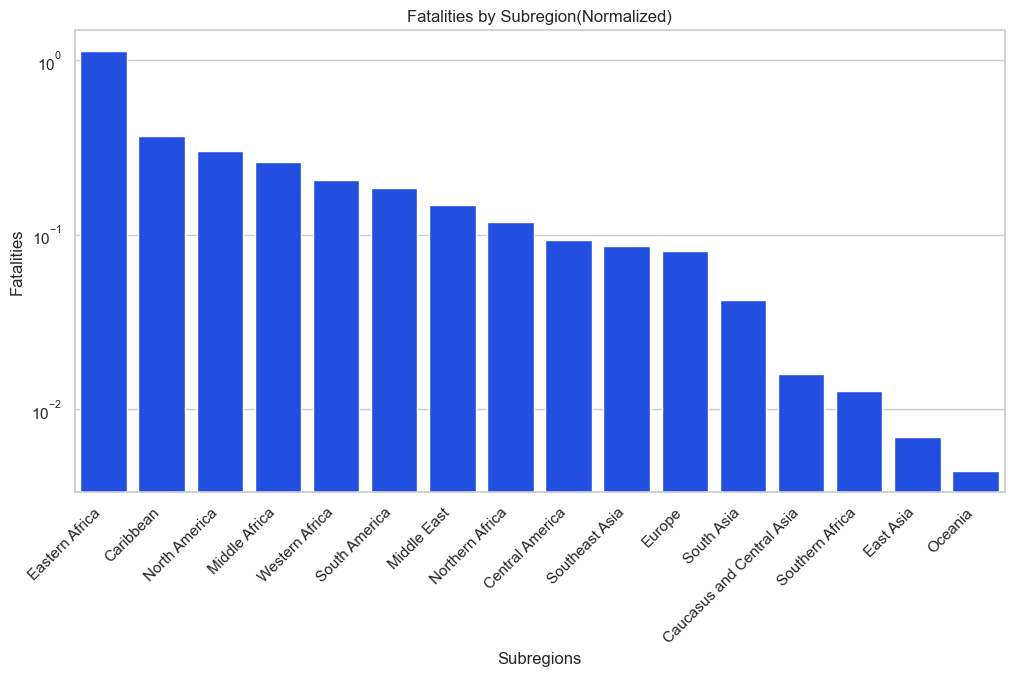

In [ ]:
#How do normalized fatalities vary across different subregions, and how does the use of a logarithmic scale help in understanding these variations, especially in regions with extreme values?
# Bar plot with manual scaling
pvtw_by_subregions = pvtw_by_subregions.sort_values(by='normalized_fatalities',ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=pvtw_by_subregions, x='Subregion', y='normalized_fatalities')
plt.yscale('log')  # Use a logarithmic scale if the values are very small or vary greatly
plt.title('Fatalities by Subregion(Normalized)')
plt.xlabel("Subregions")
plt.ylabel('Fatalities')
plt.xticks(rotation=45, ha='right')
plt.show()

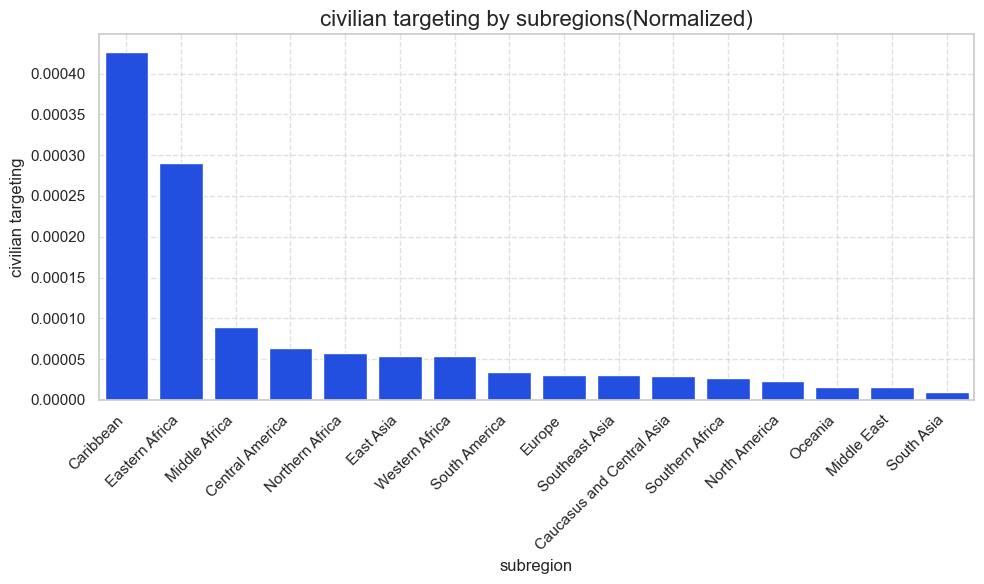

In [ ]:
pvtw_by_subregions = pvtw_by_subregions.sort_values(by='normalized_civilian_targeting',ascending=False)
plot('bar',pvtw_by_subregions,'Subregion','normalized_civilian_targeting','civilian targeting by subregions(Normalized)','subregion','civilian targeting',
     rotation=45, ha='right')